# Comprehensive Guide to Clustering Techniques

Clustering is a pivotal technique in unsupervised machine learning, allowing us to discover hidden patterns and groupings in data without predefined labels.

In this notebook, we explore three widely-used clustering methods:

1. **KMeans Clustering**: This popular algorithm partitions the dataset into K distinct, non-overlapping subsets or clusters. It minimizes the variance within each cluster, leading to compact and distinct groupings. KMeans is known for its simplicity and efficiency, making it an excellent choice for a wide range of applications.

2. **Hierarchical Clustering**: Unlike KMeans, Hierarchical clustering does not require the number of clusters to be specified in advance. This method builds a hierarchy of clusters either by a bottom-up approach (agglomerative) or a top-down approach (divisive). It is particularly useful for understanding the data structure and is often visualized using a dendrogram.

3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: DBSCAN is a robust clustering method that identifies high-density areas as clusters and treats low-density areas as noise or outliers. It's especially effective in dealing with irregularly shaped clusters and datasets with noise.

---

**Source**: [Medium](https://medium.com/ai-made-simple/k-means-clustering-e9bd722a09fa)

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs, make_moons

## K-Means Clustering

In this section, we implement K-Means clustering as a custom estimator in `Scikit-Learn`. This involves extending the `BaseEstimator` class and implementing essential methods for unsupervised learning. The primary method, `fit()`, will execute the K-Means algorithm and store important outcomes such as cluster centers and assignments. Additionally, we may include a `predict()` method for assigning new data points to the formed clusters.

In [50]:
class KMeans(BaseEstimator):
    def __init__(self, n_clusters, max_iter=100, random_seed=None, verbose=False):
        self.n_clusters = n_clusters
        self.max_iter = max_iter 
        self.random_state = np.random.RandomState(random_seed)
        self.verbose = verbose
        
    def fit(self, X):
        # Randomly select the initial centroids from the given points (with no replacement)
        idx = self.random_state.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[idx]
        if self.verbose: print('Centroids:', self.centroids)
            
        # Allocate a distances matrix between the data points and the centroids
        distances = np.zeros((len(X), self.n_clusters))
        prev_labels = None
            
        # Run the algorithm until convergence or max_iter has been reached
        for iteration in range(self.max_iter):        
            if self.verbose: print('\nIteration', iteration)
                            
            # Compute the distances to the cluster centroids
            for i in range(self.n_clusters):
                distances[:, i] = np.sum((X - self.centroids[i])**2, axis=1)
                
            # Assign each data point to the cluster with the nearest centroids
            self.labels = np.argmin(distances, axis=1) 
            if self.verbose: print('Labels:', self.labels)
            
            # Check if there was no change in the cluster assignments
            if np.all(self.labels == prev_labels):
                break
            prev_labels = self.labels
                
            # Recompute the centroids
            for i in range(self.n_clusters):
                self.centroids[i] = np.mean(X[self.labels == i], axis=0)
                
                # Handle empty clusters
                if np.isnan(self.centroids[i]).any():
                    self.centroids[i] = X[self.random_state.choice(len(X))]      
                                
            if self.verbose: print('Centroids:', self.centroids)

In [51]:
def plot_data(X):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [65]:
def plot_clusters(X, labels, centroids):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', edgecolor='k', legend=False)
    sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], marker='x', color='k', s=100, legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

In [52]:
X, y = make_blobs(n_samples=100, centers=5, random_state=10)
X = StandardScaler().fit_transform(X)

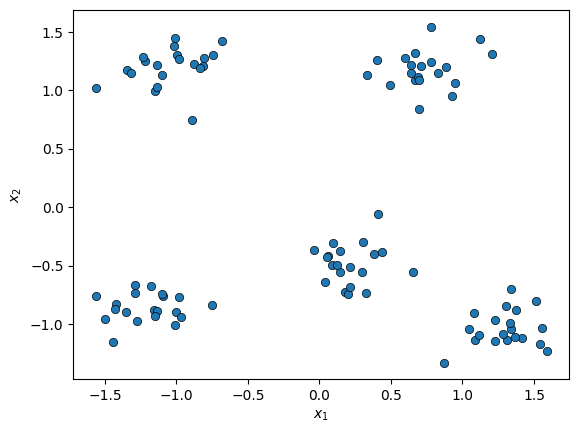

In [53]:
plot_data(X)

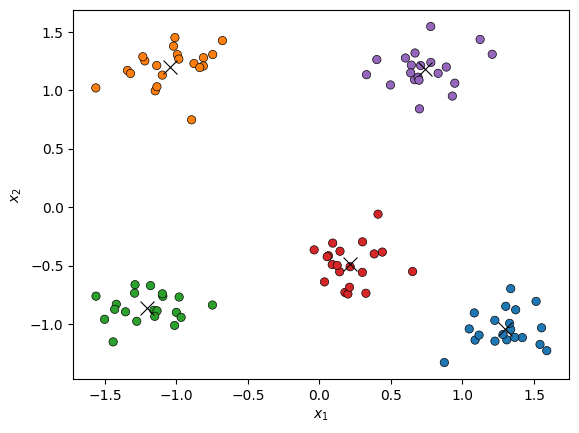

In [58]:
kmeans = KMeans(n_clusters=5, random_seed=1)  
kmeans.fit(X)

plot_clusters(X, kmeans.labels, kmeans.centroids)

The five clusters were correctly identified in this case. However, running the algorithm with a different random seed may lead to bad clustering. For example, running the algorithm with a random seed of 0 yields the following clustering:

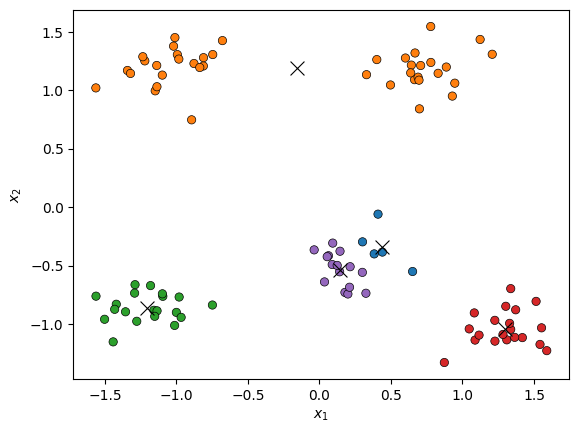

In [59]:
kmeans = KMeans(n_clusters=5, random_seed=0)  
kmeans.fit(X)

plot_clusters(X, kmeans.labels, kmeans.centroids)

In general, k-means is highly sensitive to the initial placement of the centroids. Therefore, choosing an appropriate initialization method for the algorithm is crucial for obtaining a good clustering.

### Limitations of K-Means
K-means works best when the clusters are spherical, equally sized, and well separated from each other. If the clusters are of different shapes, densities, or sizes, the algorithm might not perform well.

## Hierarchical Clustering

This section focuses on implementing Hierarchical Clustering using Scikit-Learn's `AgglomerativeClustering`. This method provides an efficient approach to produce a flat clustering based on a predefined number of clusters. Unlike generating a full dendrogram, which can be more time-consuming, `AgglomerativeClustering` streamlines the process, making it suitable for scenarios where the desired number of clusters is known in advance.

Additionally, `AgglomerativeClustering` aligns well with Scikit-Learn's ecosystem, offering ease of integration with its tools and utilities. This compatibility is reflected in the implementation of methods like `fit()` and `fit_predict()`, making it a convenient choice for use with Scikit-Learn's comprehensive suite of machine learning functionalities.

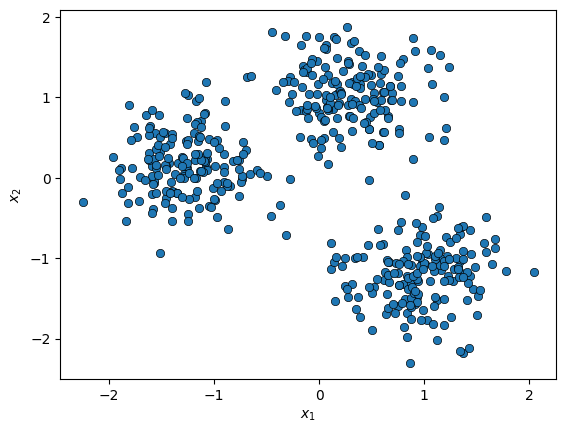

In [67]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=0.6, random_state=0)
X = StandardScaler().fit_transform(X)
plot_data(X)

In [73]:
def plot_clusters(X, labels):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', edgecolor='k', legend=False)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

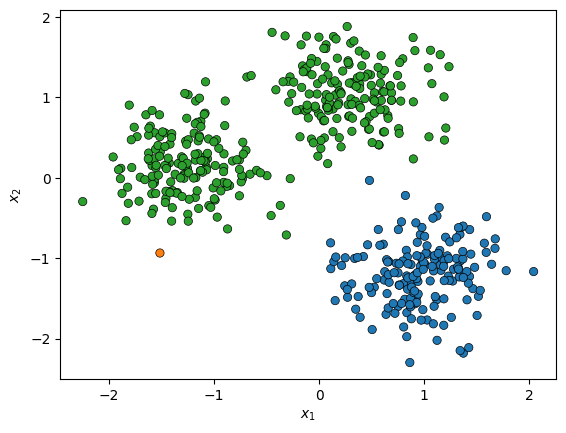

In [74]:
agg = AgglomerativeClustering(n_clusters=3, linkage='single')
agg.fit(X)

plot_clusters(X, agg.labels_)

As can be seen, single linkage was unable to identify correctly the clusters. For example, the noise points between the two upper clusters has caused it to merge the two clusters together.

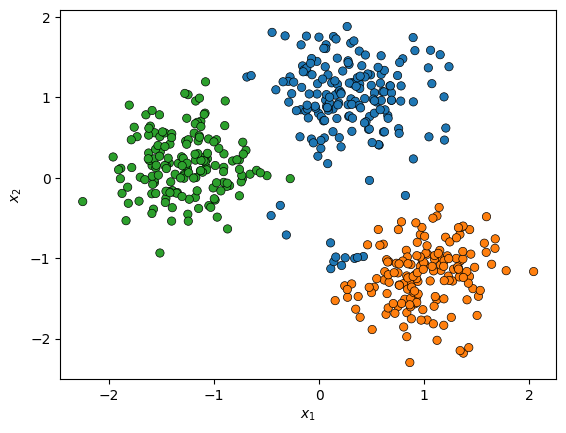

In [71]:
agg = AgglomerativeClustering(n_clusters=3, linkage='complete')
agg.fit(X)

plot_clusters(X, agg.labels_)

This time, the algorithm has identified the three clusters, but sections of the top-left and right-bottom clusters have been separated, demonstrating the tendency of complete linkage to fragment large clusters.

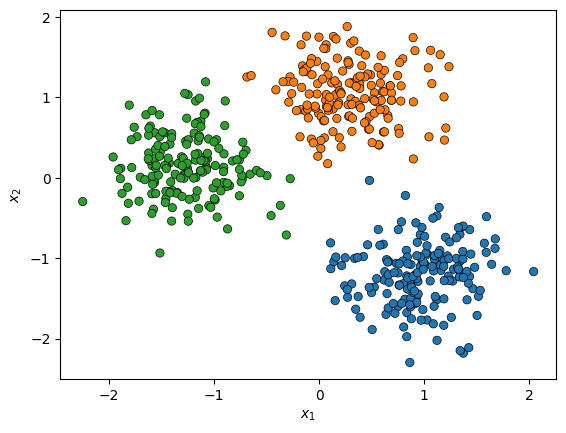

In [72]:
# default linkage is 'ward'
agg = AgglomerativeClustering(n_clusters=3, linkage='ward')
agg.fit(X)

plot_clusters(X, agg.labels_)

Ward’s method gave the best results on this dataset, since the clusters have spherical shapes and are roughly of equal size. Ward’s method aims to minimize the variance within each cluster, making it particularly suited for datasets with compact and well-defined clusters, as is the case here.

## DBSCAN

In this section, we explore the use of the DBSCAN algorithm, implemented in Scikit-Learn as `sklearn.cluster.DBSCAN`. This powerful clustering method is renowned for its ability to identify clusters of varying shapes and densities, while effectively handling noise and outliers.

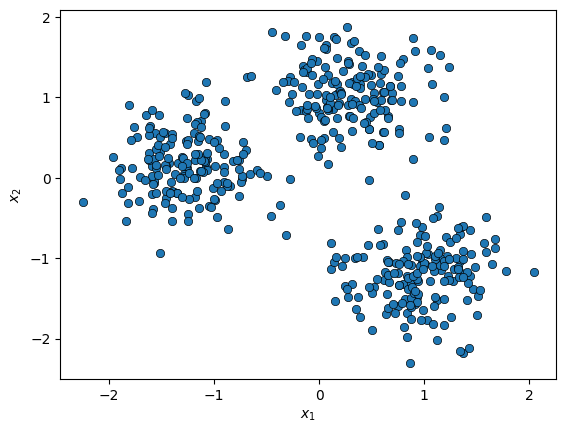

In [75]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=0.6, random_state=0)
X = StandardScaler().fit_transform(X)
plot_data(X)

In [78]:
"""
The number of clusters is determined by the number of unique labels assigned to the data points 
(stored in the labels_ attribute) minus 1 if there was at least one noise point detected (whose label is -1).
"""
def print_cluster_stats(dbscan):
    labels = dbscan.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_points = np.count_nonzero(labels == -1)

    print('Number of clusters:', n_clusters)
    print('Number of noise points:', n_noise_points)

In [79]:
dbscan = DBSCAN()
dbscan.fit(X)

print_cluster_stats(dbscan)

Number of clusters: 1
Number of noise points: 0


In [80]:
dbscan = DBSCAN(eps=0.3)
dbscan.fit(X)

print_cluster_stats(dbscan)

Number of clusters: 3
Number of noise points: 14


In [81]:
def plot_clusters(X, dbscan):
    labels = dbscan.labels_
    
    # Identify the border points
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[dbscan.core_sample_indices_] = True
    border_samples_mask = ~core_samples_mask & (labels != -1)
   
    # Identify the noise points
    noise_samples_mask = (labels == -1)
    noise_points = X[noise_samples_mask]
    
    # Assign a different dot size for each type of point
    sizes = np.zeros_like(labels, dtype=int)
    sizes[core_samples_mask] = 100
    sizes[border_samples_mask] = 50
    sizes[noise_samples_mask] = 25
    
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='tab10', edgecolor='k', 
                    s=sizes, legend=False)
    
    # Draw the noise points in black
    sns.scatterplot(x=noise_points[:, 0], y=noise_points[:, 1], color='k', legend=False)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')

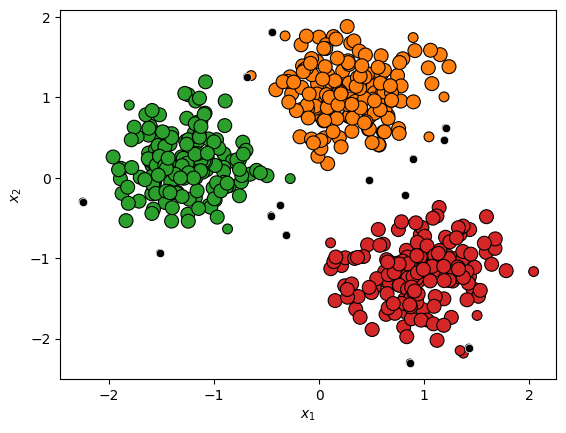

In [82]:
plot_clusters(X, dbscan)

### Choosing Algorithm Parameters for DBSCAN

DBSCAN's effectiveness heavily relies on its parameters, ϵ (epsilon) and MinPts. These parameters are dataset-specific and influence the algorithm's sensitivity to data structure and clustering objectives.

- **MinPts**: Determines tolerance to outliers. Higher MinPts results in smaller, denser clusters and more noise identification. A general guideline is to set MinPts at least to the number of dimensions in the dataset (m) plus one, allowing for an adequate assessment of local neighborhood density.

- **ϵ (epsilon)**: Balances cluster granularity and noise sensitivity. Too small ϵ leads to minimal clustering, while too large ϵ merges distinct clusters. Selecting ϵ typically involves constructing a k-distance graph, plotting distances to the k-th nearest neighbor (k often equals MinPts). The “elbow” in this graph, where distance changes sharply, suggests an optimal ϵ value.

In [83]:
def plot_k_distance_graph(X, k):
    # Compute pairwise distances between the points (using Euclidean distance)
    distances = pairwise_distances(X)
    
    # Sort the distances for each point
    sorted_distances = np.sort(distances, axis=1)
    
    # Get the distance of each point to its k-nearest neighbor
    k_distances = sorted_distances[:, k]
    
    # Sort the k-distances
    sorted_k_distances = np.sort(k_distances)
    
    # Plot the k-distance graph
    plt.plot(sorted_k_distances)
    plt.xlabel('Data Point Index')
    plt.ylabel(f'{k}-Distance')
    plt.grid()

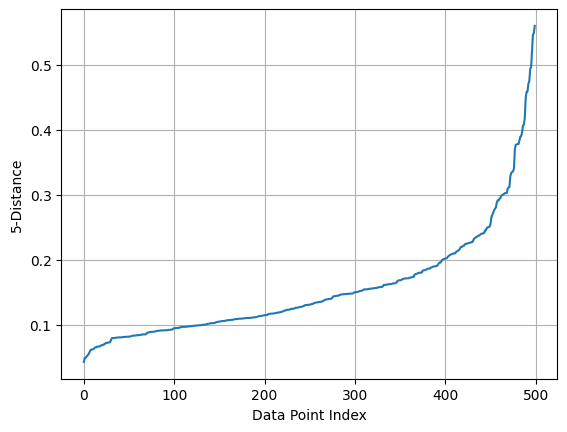

In [84]:
plot_k_distance_graph(X, k=5)

We can see that the elbow point is around a 5-distance of $0.3$, which is the value that we used for ϵ in the second run of DBSCAN.

### Handling Clusters of Arbitrary Shapes
One of the main advantages of DBSCAN over other clustering algorithms, such as k-means or hierarchical clustering, is that it can handle clusters of arbitrary shapes, as long as they have similar densities.

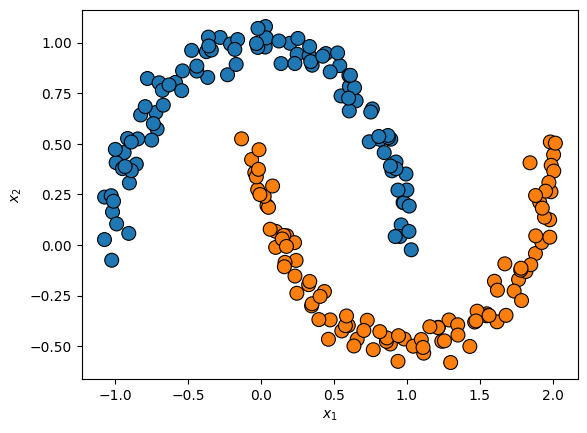

In [85]:
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

dbscan = DBSCAN(eps=0.3)
dbscan.fit(X_moons)
plot_clusters(X_moons, dbscan)